In [1]:
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
from process_datant import DataProcessor

# Loading the data
X_train = pd.read_csv('data/single_turbine_data_notemp/X_train.csv')
X_test = pd.read_csv('data/single_turbine_data_notemp/X_test.csv')
y_train = pd.read_csv('data/single_turbine_data_notemp/y_train.csv')
y_test = pd.read_csv('data/single_turbine_data_notemp/y_test.csv')

y_train['# Date and time'] = pd.to_datetime(y_train['# Date and time'])
y_test['# Date and time'] = pd.to_datetime(y_test['# Date and time'])

y_train.set_index('# Date and time', inplace=True)
y_test.set_index('# Date and time', inplace=True)

processor = DataProcessor(X_train)
processor.process_all()
X_train = processor.data

processor = DataProcessor(X_test)
processor.process_all()
X_test = processor.data

cols = [
   #  '1_Wind direction (°)', 
      #   '1_Nacelle position (°)',
      'avg_dir',
      # 'cos_wd',
      # 'cos_np',
      #  '1_Power (kW)', 
       '1_Generator RPM (RPM)', 
      #  '1_Wind direction (°)_change',
      #  '1_Nacelle position (°)_change', 
      # '1_Power (kW)_change',
      #  '1_Generator RPM (RPM)_change', 
      #  'curtailed', 
       'offline', 
      #  'cooling',
       '1_Wind speed (m/s)',
      #  'rollti',
       'avg_pitch_angle', 
      #  '1_Wind direction (°)_rollmean',
      #  '1_Wind direction (°)_rollstd', 
      #  '1_Wind direction (°)_crest_factor',
      #  '1_Nacelle position (°)_rollmean', 
      #  '1_Nacelle position (°)_rollstd',
      #  '1_Nacelle position (°)_crest_factor', 
       '1_Power (kW)_rollmean',
       '1_Power (kW)_rollstd', 
       '1_Power (kW)_crest_factor',
       '1_Generator RPM (RPM)_rollmean', 
       '1_Generator RPM (RPM)_rollstd',
       '1_Generator RPM (RPM)_crest_factor', 
      #  '1_Wind direction (°)_lead6',
      #  '1_Nacelle position (°)_lead3', 
       '1_Power (kW)_lag6',
       '1_Generator RPM (RPM)_lead6', 
      #  'month_sin', 
       'month_cos', 
      #  'hour_sin',
      #  'hour_cos', 
       '1_Gear oil temperature (°C)', 
      #  '10_m_hws_mean_mps',
    #    '10_m_hwd_mean_deg-n_true', 
      #  '100_m_hws_mean_mps',
    #    '100_m_hwd_mean_deg-n_true', 
       '2_m_temp_mean_deg-c',
      #  '2_m_dew_point_temp_deg-c', 
    #    '2_m_rh_mean_%', 
    #    '0_m_pres_mean_pa',
    #    'sea_level_pres_mean_pa', 
    #    'boundary_layer_height_m',
      #  'total_cloud_cover_%', 
       'instantaneous_surface_sensible_heat_flux_wpm2',
      #  'friction_velocity_mps', 
    #    'cloud_base_height_m',
       'surface_solar_radiation_downwards_wpm2',
      #  'historic_offline',
       ]

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

era = pd.read_csv('data/single_turbine_data_notemp/ERA5T.csv')
era['datetime_start_utc'] = pd.to_datetime(era['datetime_start_utc'])
era['datetime_start_utc'] = era['datetime_start_utc'].dt.tz_convert(None)
era.set_index('datetime_start_utc', inplace=True)
era = era.resample('10T').asfreq()
era = era.interpolate(method='linear')
train_data = pd.merge(train_data, era, left_on=train_data.index, right_on=era.index)
test_data = pd.merge(test_data, era, left_on=test_data.index, right_on=era.index)

train_data = train_data[cols]
test_data = test_data[cols]

all_data = pd.concat([train_data, test_data], axis=0)
# all_data = pd.merge(all_data, era, left_on=all_data.index, right_on=era.index)

In [2]:
# Assuming 'train_data' and 'test_data' are DataFrames created from the previous response
# Convert the data to AutoGluon's TabularDataset format
train_data = TabularDataset(train_data)
test_data = TabularDataset(test_data)
all_data = TabularDataset(all_data)

# Define the target columns
label = '1_Gear oil temperature (°C)'

# Initialize an empty dictionary to store the predictors
predictors = {}

# Train a separate regression model for each target event type
predictor = TabularPredictor(label=label, 
                              problem_type='regression', 
                              eval_metric='root_mean_squared_error',
                              
                              ) # regression with R^2 as the evaluation metric
predictor.fit(train_data, 
              # excluded_model_types=['LightGBMLarge'], 
#                   time_limit=600, 
#                   num_bag_sets = 2, 
                  # num_bag_folds = 4,
            #   hyperparameters = 'light',
              presets='best_quality',
              # feature_prune_kwargs={},
                              # auto_stack=True,
                              # time_limit=1200,
              )

No path specified. Models will be saved in: "AutogluonModels/ag-20230922_224703/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230922_224703/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Wed Jul  5 22:21:53 PDT 2023; root:xnu-8796.141.3~6/RELEASE_ARM64_T6020
Disk Space Avail:   315.65 GB / 1995.22 GB (15.8%)
Train Data Rows:    158731
Train Data Columns: 17
Label Column: 1_Gear oil temperature (°C)
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerato

[1000]	valid_set's rmse: 1.33724
[2000]	valid_set's rmse: 1.26657
[3000]	valid_set's rmse: 1.22598
[4000]	valid_set's rmse: 1.19866
[5000]	valid_set's rmse: 1.17794
[6000]	valid_set's rmse: 1.16173
[7000]	valid_set's rmse: 1.14729
[8000]	valid_set's rmse: 1.13571
[9000]	valid_set's rmse: 1.1263
[10000]	valid_set's rmse: 1.1178
[1000]	valid_set's rmse: 1.38054
[2000]	valid_set's rmse: 1.30246
[3000]	valid_set's rmse: 1.25787
[4000]	valid_set's rmse: 1.22925
[5000]	valid_set's rmse: 1.20768
[6000]	valid_set's rmse: 1.19033
[7000]	valid_set's rmse: 1.17531
[8000]	valid_set's rmse: 1.16318
[9000]	valid_set's rmse: 1.153
[10000]	valid_set's rmse: 1.14453
[1000]	valid_set's rmse: 1.35067
[2000]	valid_set's rmse: 1.27358
[3000]	valid_set's rmse: 1.23289
[4000]	valid_set's rmse: 1.20509
[5000]	valid_set's rmse: 1.18395
[6000]	valid_set's rmse: 1.16681
[7000]	valid_set's rmse: 1.15249
[8000]	valid_set's rmse: 1.14054
[9000]	valid_set's rmse: 1.12983
[10000]	valid_set's rmse: 1.121
[1000]	valid_

	-1.124	 = Validation score   (-root_mean_squared_error)
	633.6s	 = Training   runtime
	11.63s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 1.25033
[2000]	valid_set's rmse: 1.18814
[3000]	valid_set's rmse: 1.15627
[4000]	valid_set's rmse: 1.13501
[5000]	valid_set's rmse: 1.11965
[6000]	valid_set's rmse: 1.10904
[7000]	valid_set's rmse: 1.09936
[8000]	valid_set's rmse: 1.09182
[9000]	valid_set's rmse: 1.0868
[10000]	valid_set's rmse: 1.08284
[1000]	valid_set's rmse: 1.28878
[2000]	valid_set's rmse: 1.21913
[3000]	valid_set's rmse: 1.18345
[4000]	valid_set's rmse: 1.16418
[5000]	valid_set's rmse: 1.15031
[6000]	valid_set's rmse: 1.1383
[7000]	valid_set's rmse: 1.12981
[8000]	valid_set's rmse: 1.12154
[9000]	valid_set's rmse: 1.11553
[10000]	valid_set's rmse: 1.10996
[1000]	valid_set's rmse: 1.25904
[2000]	valid_set's rmse: 1.19224
[3000]	valid_set's rmse: 1.1602
[4000]	valid_set's rmse: 1.13779
[5000]	valid_set's rmse: 1.12161
[6000]	valid_set's rmse: 1.10956
[7000]	valid_set's rmse: 1.10101
[8000]	valid_set's rmse: 1.09423
[9000]	valid_set's rmse: 1.08758
[10000]	valid_set's rmse: 1.08282
[1000]	val

	-1.0911	 = Validation score   (-root_mean_squared_error)
	592.03s	 = Training   runtime
	10.99s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ...
	-1.1977	 = Validation score   (-root_mean_squared_error)
	64.4s	 = Training   runtime
	3.28s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-1.147	 = Validation score   (-root_mean_squared_error)
	519.38s	 = Training   runtime
	0.24s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ...
	-1.1715	 = Validation score   (-root_mean_squared_error)
	6.55s	 = Training   runtime
	3.07s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-1.419	 = Validation score   (-root_mean_squared_error)
	1273.0s	 = Training   runtime
	2.04s	 = Validation runtime
Fitting model: XGBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fittin

[1000]	valid_set's rmse: 1.15531
[2000]	valid_set's rmse: 1.10952
[3000]	valid_set's rmse: 1.08582
[4000]	valid_set's rmse: 1.0713
[5000]	valid_set's rmse: 1.06244
[6000]	valid_set's rmse: 1.05558
[7000]	valid_set's rmse: 1.05078
[8000]	valid_set's rmse: 1.04739
[9000]	valid_set's rmse: 1.04463
[10000]	valid_set's rmse: 1.0423
[1000]	valid_set's rmse: 1.19286
[2000]	valid_set's rmse: 1.1427
[3000]	valid_set's rmse: 1.11669
[4000]	valid_set's rmse: 1.10361
[5000]	valid_set's rmse: 1.09373
[6000]	valid_set's rmse: 1.08778
[7000]	valid_set's rmse: 1.08368
[8000]	valid_set's rmse: 1.07996
[9000]	valid_set's rmse: 1.07702
[10000]	valid_set's rmse: 1.07476
[1000]	valid_set's rmse: 1.17837
[2000]	valid_set's rmse: 1.13184
[3000]	valid_set's rmse: 1.10907
[4000]	valid_set's rmse: 1.09428
[5000]	valid_set's rmse: 1.08439
[6000]	valid_set's rmse: 1.07711
[7000]	valid_set's rmse: 1.07116
[8000]	valid_set's rmse: 1.06633
[9000]	valid_set's rmse: 1.06305
[10000]	valid_set's rmse: 1.06095
[1000]	val

	-1.0553	 = Validation score   (-root_mean_squared_error)
	2132.44s	 = Training   runtime
	13.49s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-1.0516	 = Validation score   (-root_mean_squared_error)
	0.79s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 9 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 1.02344
[2000]	valid_set's rmse: 1.01734
[3000]	valid_set's rmse: 1.01438
[4000]	valid_set's rmse: 1.01313
[5000]	valid_set's rmse: 1.01258
[6000]	valid_set's rmse: 1.01214
[7000]	valid_set's rmse: 1.01213
[8000]	valid_set's rmse: 1.01205
[1000]	valid_set's rmse: 1.03386
[2000]	valid_set's rmse: 1.02431
[3000]	valid_set's rmse: 1.02092
[4000]	valid_set's rmse: 1.01942
[5000]	valid_set's rmse: 1.01847
[6000]	valid_set's rmse: 1.01838
[7000]	valid_set's rmse: 1.01837
[8000]	valid_set's rmse: 1.01817
[9000]	valid_set's rmse: 1.01849
[10000]	valid_set's rmse: 1.01871
[1000]	valid_set's rmse: 1.03064
[2000]	valid_set's rmse: 1.023
[3000]	valid_set's rmse: 1.01968
[4000]	valid_set's rmse: 1.01799
[5000]	valid_set's rmse: 1.0178
[6000]	valid_set's rmse: 1.01747
[1000]	valid_set's rmse: 1.02208
[2000]	valid_set's rmse: 1.01424
[3000]	valid_set's rmse: 1.01081
[4000]	valid_set's rmse: 1.00939
[5000]	valid_set's rmse: 1.00875
[6000]	valid_set's rmse: 1.00858
[7000]	valid

	-1.0149	 = Validation score   (-root_mean_squared_error)
	637.03s	 = Training   runtime
	6.15s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 1.01062
[2000]	valid_set's rmse: 1.01038
[1000]	valid_set's rmse: 1.02315
[2000]	valid_set's rmse: 1.02121
[3000]	valid_set's rmse: 1.02155
[1000]	valid_set's rmse: 1.02654
[2000]	valid_set's rmse: 1.026
[1000]	valid_set's rmse: 1.0152
[2000]	valid_set's rmse: 1.01342
[1000]	valid_set's rmse: 1.01736
[2000]	valid_set's rmse: 1.01619
[3000]	valid_set's rmse: 1.01678
[1000]	valid_set's rmse: 1.00894
[1000]	valid_set's rmse: 1.03804
[1000]	valid_set's rmse: 1.01911


	-1.0187	 = Validation score   (-root_mean_squared_error)
	154.95s	 = Training   runtime
	1.19s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ...
	-1.024	 = Validation score   (-root_mean_squared_error)
	116.59s	 = Training   runtime
	4.1s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-1.0131	 = Validation score   (-root_mean_squared_error)
	237.43s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L2 ...
	-1.0222	 = Validation score   (-root_mean_squared_error)
	10.8s	 = Training   runtime
	3.69s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-1.0295	 = Validation score   (-root_mean_squared_error)
	2079.65s	 = Training   runtime
	3.14s	 = Validation runtime
Fitting model: XGBoost_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitt

[1000]	valid_set's rmse: 1.00714
[1000]	valid_set's rmse: 1.0234
[2000]	valid_set's rmse: 1.02276
[1000]	valid_set's rmse: 1.02152
[1000]	valid_set's rmse: 1.0101
[1000]	valid_set's rmse: 1.01142
[2000]	valid_set's rmse: 1.01108
[1000]	valid_set's rmse: 1.00212
[1000]	valid_set's rmse: 1.03452
[2000]	valid_set's rmse: 1.03366
[1000]	valid_set's rmse: 1.01508
[2000]	valid_set's rmse: 1.01453


	-1.0148	 = Validation score   (-root_mean_squared_error)
	475.15s	 = Training   runtime
	1.59s	 = Validation runtime
Fitting model: WeightedEnsemble_L3 ...
	-1.006	 = Validation score   (-root_mean_squared_error)
	0.83s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 27584.13s ... Best model: "WeightedEnsemble_L3"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20230922_224703/")


In [3]:
result_dict = predictor.evaluate(test_data, model='WeightedEnsemble_L2')

Evaluation: root_mean_squared_error on test data: -1.6630027703293218
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -1.6630027703293218,
    "mean_squared_error": -2.7655782141229985,
    "mean_absolute_error": -1.1818433299643345,
    "r2": 0.9009884259956088,
    "pearsonr": 0.954178615620075,
    "median_absolute_error": -0.8975042343139492
}


* 2.58 with all era and no wind speed
* 2.54 with ws and less era and no wind speed
* 2.55 with wind speed
* 2.52 with long train
* 2.62 short, without any nacelle pos or wind direction
* 2.59 short with avg cos wind direction nacelle direction
* 2.60 without avg and individual wind dir and nacelle dir
* 2.59 without power or curtailed, offline for gen speed<1000
* 2.62 with cooling
* 2.62 without acitve power mean std crest
* 2.61 with power rolling mean
* 2.63 with rollti
* 2.62 with power stats
* 2.699 no power, no crest factors, no direction lead/lags
* 2.61 'avg_dir', '1_Generator RPM (RPM)', 'offline', 'avg_pitch_angle',
       '1_Power (kW)_rollmean', '1_Power (kW)_rollstd',
       '1_Power (kW)_crest_factor', '1_Generator RPM (RPM)_rollmean',
       '1_Generator RPM (RPM)_rollstd', '1_Generator RPM (RPM)_crest_factor',
       '1_Power (kW)_lag6', '1_Generator RPM (RPM)_lead6', 'month_cos',
       'hour_cos', '1_Gear oil temperature (°C)', '10_m_hws_mean_mps',
       '100_m_hws_mean_mps', '2_m_temp_mean_deg-c', '2_m_dew_point_temp_deg-c',
       'total_cloud_cover_%', 'instantaneous_surface_sensible_heat_flux_wpm2',
       'friction_velocity_mps', 'surface_solar_radiation_downwards_wpm2'
* 2.59 'avg_dir', '1_Generator RPM (RPM)', 'offline', 'avg_pitch_angle',
       '1_Power (kW)_rollmean', '1_Power (kW)_rollstd',
       '1_Power (kW)_crest_factor', '1_Generator RPM (RPM)_rollmean',
       '1_Generator RPM (RPM)_rollstd', '1_Generator RPM (RPM)_crest_factor',
       '1_Power (kW)_lag6', '1_Generator RPM (RPM)_lead6', 'month_cos',
       '1_Gear oil temperature (°C)', '2_m_temp_mean_deg-c',
       'instantaneous_surface_sensible_heat_flux_wpm2',
       'surface_solar_radiation_downwards_wpm2'
* 2.54 adjusted ws
* 2.558 historic offline
* 2.26 historic offline and window size 12 past
* 2.257 12
* 2.39 10
* 2.48 8
* 1.99 20
* 1.80 30
* 1.70 40
* 1.63 50
* 1.66 60

In [8]:
data = pd.read_csv('data/evaluation_data/X_single_turbine.csv')

# concat the last 50 rows of all_data to the start of data
data = pd.concat([all_data[-50:], data], axis=0)

processor = DataProcessor(data)
processor.process_all()
data = processor.data
data = data[cols]
data = TabularDataset(data)

# drop the rows again
data = data.iloc[50:]

# load the predictor from the directory
from autogluon.tabular import TabularDataset, TabularPredictor

# predictor = TabularPredictor.load('AutogluonModels/ag-20230921_142236')

results = predictor.predict(data, model='WeightedEnsemble_L3')

0.48658 without folds
0.489 with folds

In [4]:
npres = results.to_numpy().flatten()

In [11]:
# create submission
submission = pd.read_csv('data/evaluation_data/y_template.csv')
submission['1_Gear oil temperature (°C)'] = results.to_numpy().flatten()
submission.to_csv('submission_jhyland_no_temp_ag.csv', index=False)

In [12]:
submission.head(-5)

,# Date and time,1_Gear oil temperature (°C)
0,2020-06-16 08:20:00,36.876408
1,2020-06-16 08:30:00,36.952736
2,2020-06-16 08:40:00,37.124241
3,2020-06-16 08:50:00,36.869080
4,2020-06-16 09:00:00,38.806095
...,...,...
51985,2021-06-16 06:50:00,56.653412
51986,2021-06-16 07:00:00,55.484661
51987,2021-06-16 07:10:00,54.739395
51988,2021-06-16 07:20:00,54.730854


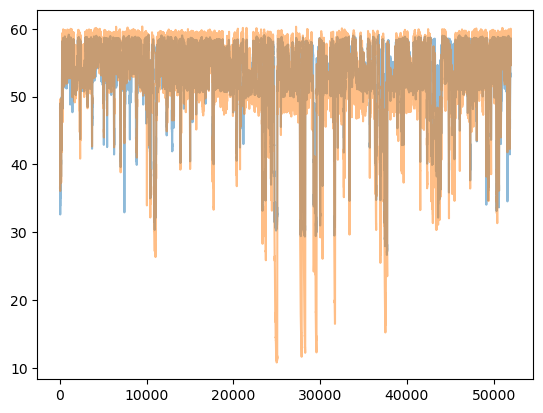

In [7]:
import matplotlib.pyplot as plt

ag = pd.read_csv('submission_jhyland_ag.csv')
nn = pd.read_csv('submission_jhyland_nn.csv')

plt.plot(range(len(ag)),ag['1_Gear oil temperature (°C)'], alpha=0.5)
plt.plot(range(len(nn)),nn['1_Gear oil temperature (°C)'], alpha=0.5)

In [1]:
import pandas as pd

ag = pd.read_csv('submission_jhyland_ag.csv')
nn = pd.read_csv('submission_jhyland_nn.csv')

# average the two
avg = (ag['1_Gear oil temperature (°C)'] + nn['1_Gear oil temperature (°C)'])/2

submission = pd.read_csv('data/evaluation_data/y_template.csv')
submission['1_Gear oil temperature (°C)'] = avg
submission.to_csv('submission_jhyland_avgnnag.csv', index=False)